In [28]:
import numpy as np
import pandas as pd
import re
from collections import Counter
from scipy import special
# import matplotlib.pyplot as plt
# %matplotlib inline 
import random
import cProfile
# import sys
# sys.path.append('/Users/jingy/Desktop/thoth')
# import thoth 

In [36]:
data = pd.read_csv('../data/sherlock_current_wtext.csv')

In [37]:
# df = data.head(100)

In [38]:
# df.to_csv('../data/sample.csv', index = False)

In [39]:
# df = pd.read_csv('../data/sample.csv')

In [40]:
def preprocess(df):
    #pre-processing
    #input: a slice of the original df
    #output: a list of lists each containing cleaned words from a work
    df = df.astype(str)
    df = df.groupby(['Additional_Tags', 'Archive_Warnings', 'Author', 'Bookmarks',\
               'Category', 'Chapters', 'Characters', 'Comments', 'CompleteDate',\
               'Fandoms', 'Hits', 'Kudos', 'Language', 'PublishDate',\
                 'Rating', 'Relationship', 'Summary', 'Title', 'Words'])['Text'].apply(','.join).reset_index()
    text = df[['Text']]
    text['Text'] = text['Text'].str.replace('A', '')
    text = text.drop_duplicates().Text.str.lower().str.split()
    text_cleaned = []
    for line in text:
        line = [re.sub(r'[^A-Za-z0-9]+', '', str(word)) for word in line]
        line = [word for word in line if len(word) > 1 and not word.isdigit()]
        text_cleaned.append(line)
    return text_cleaned

In [41]:
def preprocess_sampled(df):
    #pre-processing
    #input: a slice of the original df
    #output: a list of lists each containing cleaned words from a work
    df = df.astype(str)
    text = df[['Text']]
    text['Text'] = text['Text'].str.replace('A', '')
    text = text.drop_duplicates().Text.str.lower().str.split()
    text_cleaned = []
    for line in text:
        line = [re.sub(r'[^A-Za-z0-9]+', '', str(word)) for word in line]
        line = [word for word in line if len(word) > 1 and not word.isdigit()]
        text_cleaned.append(line)
    
    if len(text_cleaned) > 100:
        text_sample = []
        while len(text_sample) < 100:
            text_sample.append(random.choice(text_cleaned))
    else:
        text_sample = text_cleaned
    return text_sample

In [42]:
def filter_length(text, word_limit):
    return [line for line in text if len(line) > word_limit]

In [43]:
def filter_top_words(text, top_number):
    corpus = [word for line in text for word in line]
    c = Counter(corpus)
    top = [i[0] for i in c.most_common(top_number)]
    text_intop = []
    for line in text:
        line = [word for word in line if word in top]
        text_intop.append(line)
    return text_intop

In [44]:
def calculate_prob_matrix(text_list):
    #vectorize the words and turn each work into a list of word frequences over the whole vocalburary.
    #input: a list of list of words.
    #output: np array.
    vocabulary = list(set([word for text in text_list for word in text]))
    text_prob_matrix = []
    for text in text_list:
        freq_list = []
        c = Counter(text)
        for word in vocabulary:
            if word in text:
                freq_list.append(c[word])
            else:
                freq_list.append(0)
        s = float(sum(freq_list))
        if s != 0:
            text_prob = [freq/s for freq in freq_list]
            text_prob_matrix.append(text_prob)
    text_prob_matrix = np.asarray(text_prob_matrix)
    return text_prob_matrix

In [45]:
# def calculate_freq_matrix(text_list):    
#     vocabulary = list(set([word for text in text_list for word in text]))
#     text_freq_matrix = []
#     for text in text_list:
#         freq_list = []
#         c = Counter(text)
#         for word in vocabulary:
#             if word in text:
#                 freq_list.append(c[word])
#             else:
#                 freq_list.append(0)
#         text_freq_matrix.append(freq_list)
#     text_freq_matrix = np.asarray(text_freq_matrix)
#     return text_freq_matrix

In [46]:
def calculate_pairwise_jsd(p, q):
    #input: two lists of probablity distributions
    #output: jsd value
    m = [(p[i]+q[i])/2 for i in range(len(p)) ]
    kl_pm = [p[i]*(np.log(p[i]/m[i])) for i in range(len(p))]
    kl_pm = sum([v for v in kl_pm if not np.isnan(v)])
    kl_qm = [q[i]*(np.log(q[i]/m[i])) for i in range(len(q))]
    kl_qm = sum([u for u in kl_qm if not np.isnan(u)])
    kl = kl_pm/2 + kl_qm/2
    
    return kl

In [47]:
def JSD(P, Q):
    M = 0.5 * (P + Q)
    return 0.5 * (sum(special.rel_entr(P, M)) + sum(special.rel_entr(Q, M)))

In [69]:
l1 = [0.0, 0.5, 0.5]
l2 = [0.7, 0.3, 0.0]

In [70]:
calculate_pairwise_jsd(l1, l2)

0.42852188529675245

In [71]:
JSD(np.asarray(l1), np.asarray(l2))

0.42852188529675245

In [51]:
m = np.random.randn(2, 1000)

In [52]:
cProfile.run('calculate_pairwise_jsd(m[0], m[1])')

         11 function calls in 0.011 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.011    0.011    0.011    0.011 <ipython-input-46-a166be63c584>:1(calculate_pairwise_jsd)
        1    0.000    0.000    0.011    0.011 <string>:1(<module>)
        3    0.000    0.000    0.000    0.000 {len}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        3    0.000    0.000    0.000    0.000 {range}
        2    0.000    0.000    0.000    0.000 {sum}




In [53]:
cProfile.run('JSD(np.asarray(m[0]), np.asarray(m[1]))')

         9 function calls in 0.001 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.001    0.001 <ipython-input-47-04e3911f4028>:1(JSD)
        1    0.000    0.000    0.001    0.001 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 numeric.py:406(asarray)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        2    0.000    0.000    0.000    0.000 {numpy.core.multiarray.array}
        2    0.000    0.000    0.000    0.000 {sum}




In [54]:
# def calculate_pairwise_jsd2(p, q):
#     return thoth.calc_jsd(p, q, 0.5, 10000)[0]

In [80]:
def calculate_monthly_jsd(matrix):
    jsds = []
    for i in range(matrix.shape[0]):
        for j in range(i+1, matrix.shape[0]):
            jsds.append(calculate_pairwise_jsd(matrix[i], matrix[j]))
    return jsds

In [56]:
# def calculate_monthly_jsd2(matrix):
#     jsds = []
#     for i in range(matrix.shape[0]):
#         for j in range(i+1, matrix.shape[0]):
#             jsds.append(calculate_pairwise_jsd2(matrix[i], matrix[j]))
#     return jsds

In [57]:
def bootstrap_resample(jsd_list):
    ave_original = np.average(jsd_list)
    aves = []
    for i in range(1000):
        sample = []
        for i in range(len(jsd_list)):
            sample.append(random.choice(jsd_list))
        aves.append(np.average(sample))
    tail = sorted(aves)[24]
    head = sorted(aves)[975]
    return (ave_original, tail, head)

In [58]:
def create_df_time(df, time):
    return df[df.PublishDate.str[:7] == time]

In [59]:
timelist = data.PublishDate.drop_duplicates().tolist()
timelist = [str(i)[:7] for i in timelist]
timelist = sorted(list(set(timelist)))[3:]

In [78]:
def calculate_overall_jsd():
    jsds_timerange = []
    work_count = []
    for month in timelist[1:]:
        df_ts = create_df_time(data, month)
        text = preprocess(df_ts)
        text = filter_length(text, 500)
        work_count.append(len(text))
        text = filter_top_words(text, 1000)
        
        matrix = calculate_prob_matrix(text)
        monthly_jsds = calculate_monthly_jsd(matrix)
        monthly_ave_resampled_jsds = bootstrap_resample(monthly_jsds)
        jsds_timerange.append(monthly_ave_resampled_jsds)
        print "Finished calculation for: ", month, 'jsd = ', monthly_ave_resampled_jsds
        break
    return jsds_timerange, work_count


In [79]:
cProfile.run('calculate_overall_jsd()')

Finished calculation for:  2010-08 jsd =  (0.21581526373685017, 0.21500299513185459, 0.21662627422373976)
         53434784 function calls (53434335 primitive calls) in 30.961 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.375    0.375    1.573    1.573 <ipython-input-40-85bb1c81b3b4>:1(preprocess)
        1    0.000    0.000    0.000    0.000 <ipython-input-42-137fefa07375>:1(filter_length)
        1    2.197    2.197    2.460    2.460 <ipython-input-43-e15350c5f03e>:1(filter_top_words)
        1    3.043    3.043    3.229    3.229 <ipython-input-44-b7fdfaff645c>:1(calculate_prob_matrix)
    12561    0.498    0.000    3.754    0.000 <ipython-input-47-04e3911f4028>:1(JSD)
        1    6.412    6.412   19.702   19.702 <ipython-input-57-47a28e9eace9>:1(bootstrap_resample)
        1    0.003    0.003    0.192    0.192 <ipython-input-58-995653271a1f>:1(create_df_time)
        1    0.027    0.027    3.784    3.78

/Users/jingy/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [81]:
cProfile.run('calculate_overall_jsd()')

Finished calculation for:  2010-08 jsd =  (0.21581526373685017, 0.21496919795842451, 0.21667191173397851)
         53510150 function calls (53509701 primitive calls) in 119.022 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.357    0.357    1.447    1.447 <ipython-input-40-85bb1c81b3b4>:1(preprocess)
        1    0.000    0.000    0.000    0.000 <ipython-input-42-137fefa07375>:1(filter_length)
        1    2.180    2.180    2.431    2.431 <ipython-input-43-e15350c5f03e>:1(filter_top_words)
        1    2.937    2.937    3.125    3.125 <ipython-input-44-b7fdfaff645c>:1(calculate_prob_matrix)
    12561   90.971    0.007   92.050    0.007 <ipython-input-46-a166be63c584>:1(calculate_pairwise_jsd)
        1    6.336    6.336   19.608   19.608 <ipython-input-57-47a28e9eace9>:1(bootstrap_resample)
        1    0.003    0.003    0.158    0.158 <ipython-input-58-995653271a1f>:1(create_df_time)
        1    0.014    0.

/Users/jingy/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
# def calculate_overall_jsd2():
#     jsds_timerange = []
#     work_count = []
#     for month in timelist[1:]:
#         df_ts = create_df_time(data, month)
#         text = preprocess_sampled(df_ts)
#         text = filter_length(text, 500)
#         work_count.append(len(text))
#         text = filter_top_words(text, 1000)
        
#         matrix = calculate_freq_matrix(text)
#         monthly_jsds = calculate_monthly_jsd2(matrix)
#         monthly_ave_resampled_jsds = bootstrap_resample(monthly_jsds)
#         jsds_timerange.append(monthly_ave_resampled_jsds)
#         print "Finished calculation for: ", month, 'jsd = ', monthly_ave_resampled_jsds
#         break
#     return jsds_timerange, work_count


In [28]:
# sample = create_df_time(data, "2010-08")

In [29]:
# sample = preprocess(sample)

In [30]:
# sample = filter_length(sample, 500)

In [31]:
# sample = filter_top_words(sample, 1000)

In [32]:
# sample = calculate_prob_matrix(sample)

In [33]:
# sample = calculate_freq_matrix(sample)

In [34]:
# sample = calculate_monthly_jsd(sample)

In [35]:
# cProfile.run('bootstrap_resample(sample)')

In [117]:
def count_work():
    work_count = []
    for month in timelist:
        df_ts = create_df_time(data, month)
#         text = preprocess(df_ts)
#         text = filter_length(text, 500)
        work_count.append(len(df_ts))
    return work_count


In [118]:
# work_count = count_work()

In [59]:
import entropy as et
et.jensen_shannon_divergence(np.asarray([l1, l2]))

array([ 0.6182264])

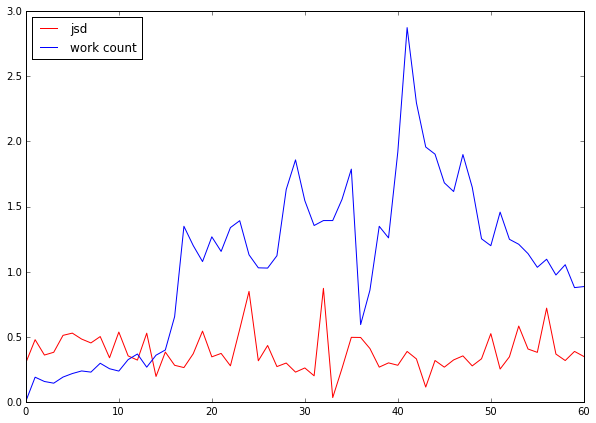

In [152]:
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111)
ax.plot(jsds_timerange, c = 'r')
ax.plot([float(i)/1000 for i in work_count], c = 'b')
# plt.yscale('log')
plt.legend(['jsd', 'work count'], loc='upper left')

<Container object of 3 artists>

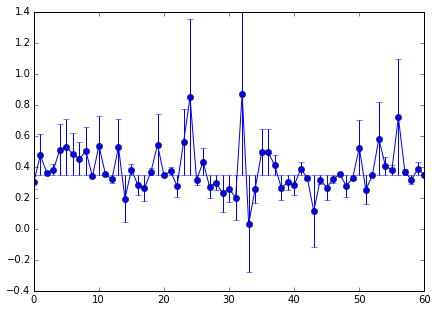

In [174]:
plt.figure(figsize = (7, 5))
plt.errorbar(range(len(jsds_timerange)), jsds_timerange, yerr=yerr, marker='o')

In [60]:
jsds_timerange

[(0.26061413508380532, 0.20670497370828259, 0.31213169091454107),
 (0.30961156020117225, 0.30728714480999253, 0.31187179919134633),
 (0.30878504820221253, 0.30635659852678465, 0.31118510669072158),
 (0.30463239658381613, 0.30236136250936163, 0.30689306184394299),
 (0.31961666459508298, 0.31712718698690456, 0.32233687265254379),
 (0.33388124358214433, 0.33054223977713387, 0.33693934203306841),
 (0.28704473519536139, 0.28406846813334063, 0.28988966054334048),
 (0.31802523537802885, 0.315677517271434, 0.32042766120496535),
 (0.30552512318942782, 0.30297367587228996, 0.3080258893127592),
 (0.28764939912929943, 0.28505694553485905, 0.2899885915703746),
 (0.30785741867512312, 0.30596903485073662, 0.30976447504020249),
 (0.30716772607557724, 0.30487912548805846, 0.3094092304347793),
 (0.30967419743954411, 0.30683311754906217, 0.31234967184325613),
 (0.32612320546158913, 0.32352094453277297, 0.32862073571951234),
 (0.31206785756206162, 0.30974974848935072, 0.31436481395622656),
 (0.31385972029